## Κωδικοποίηση: 

Να προτείνετε μια κωδικοποίηση για τα άτομα του πληθυσμού. Λάβετε
υπόψη τα παρακάτω:
i.
 Ένα άτομο αναπαριστά ένα διάνυσμα που αντιστοιχεί στις τιμές των 4 αισθητήρων που
φέρει το ρομπότ (συνολικά 12 τιμές - δεν είναι ανάγκη να χρησιμοποιήσουμε και τις 12).
ii.
Το εύρος των τιμών αυτών ενδέχεται να επηρεάσει τις μετρικές ομοιότητας και τη
συνάρτηση καταλληλότητας που θα χρησιμοποιήσετε παρακάτω. Προτείνεται η χρήση
προεπεξεργασίας/κανονικοποίησης όπως κάνατε στο Α.

In [139]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
import pygad


# Load the PUC-Rio dataset
df = pd.read_csv('dataset-HAR-PUC-Rio.csv', delimiter=';', decimal = ",", low_memory=False)

#Maybe irrelevant columns
df = df.drop(['user', 'gender', 'age', 'how_tall_in_meters', 'weight', 'body_mass_index'], axis=1)

#Drop rows with NaN values
df=df.dropna()


df.describe()
df.head()

,x1,y1,z1,x2,y2,z2,x3,y3,z3,x4,y4,z4,Class
0,-3,92,-63,-23,18,-19,5,104,-92,-150,-103,-147,sitting
1,-3,94,-64,-21,18,-18,-14,104,-90,-149,-104,-145,sitting
2,-1,97,-61,-12,20,-15,-13,104,-90,-151,-104,-144,sitting
3,-2,96,-57,-15,21,-16,-13,104,-89,-153,-103,-142,sitting
4,-1,96,-61,-13,20,-15,-13,104,-89,-153,-104,-143,sitting


In [140]:
from sklearn.preprocessing import LabelEncoder

# Label encoding of categorical target data (Class)
le = LabelEncoder()
df.Class = le.fit_transform(df.Class)
df.head()



,x1,y1,z1,x2,y2,z2,x3,y3,z3,x4,y4,z4,Class
0,-3,92,-63,-23,18,-19,5,104,-92,-150,-103,-147,0
1,-3,94,-64,-21,18,-18,-14,104,-90,-149,-104,-145,0
2,-1,97,-61,-12,20,-15,-13,104,-90,-151,-104,-144,0
3,-2,96,-57,-15,21,-16,-13,104,-89,-153,-103,-142,0
4,-1,96,-61,-13,20,-15,-13,104,-89,-153,-104,-143,0


In [141]:
# Select only accelerometer readings columns (assuming their names are 'x1', 'y1', ..., 'z4')
accelerometer_cols = ['x1', 'y1', 'z1', 'x2', 'y2', 'z2', 'x3', 'y3', 'z3', 'x4', 'y4', 'z4']

# Nomalization
scaler = MinMaxScaler(feature_range=(-1, 1))
df[accelerometer_cols] = scaler.fit_transform(df[accelerometer_cols])

# Standardization
scaler = StandardScaler()
df[accelerometer_cols] = scaler.fit_transform(df[accelerometer_cols])

# b. Isolate the "sitting" measurements and the measurements for other postures
df_sitting = df[df['Class'] == 0]
df_not_sitting = df[df['Class'] != 0]

# Drop the 'Class' column from both DataFrames
#df_sitting = df_sitting.drop('Class', axis=1)
#df_not_sitting = df_not_sitting.drop('Class', axis=1)

# c. Compute the average accelerometer readings for the "sitting" posture and for other postures
average_sitting = df_sitting[accelerometer_cols].mean().to_numpy()
average_not_sitting = df_not_sitting[accelerometer_cols].mean().to_numpy()



print("Average normalized accelerometer readings for 'sitting': ")
print(average_sitting)
print("\nAverage normalized accelerometer readings for other postures: ")
print(average_not_sitting)

# Save normalized dataset if needed
df.to_csv('normalized_puc-rio-data.csv', index=False)

Average normalized accelerometer readings for 'sitting': 
[-0.04184534 -0.93349479  1.10724424  0.17063137 -0.01514425  0.45562091
  0.11352494 -0.29607209 -0.03319776  0.93729891 -0.86195066 -0.17624456]

Average normalized accelerometer readings for other postures: 
[ 0.01842291  0.4109822  -0.48747746 -0.07512249  0.00666744 -0.20059253
 -0.0499807   0.13034926  0.01461571 -0.41265701  0.37948404  0.07759377]


## Δ' Υπολογισμός ομοιότητας

Η ομοιότητα συνημιτονίου είναι συχνά μια καλή επιλογή σε χώρους υψηλών διαστάσεων, καθώς δεν επηρεάζεται από το μέγεθος των διανυσμάτων, σε αντίθεση με μετρήσεις όπως η Ευκλείδεια απόσταση. Αυτό μπορεί να είναι σημαντικό σε σενάρια όπως αυτό, όπου οι απόλυτες τιμές των μετρήσεων του αισθητήρα μπορεί να μην είναι τόσο σημαντικές όσο οι σχετικές αναλογίες μεταξύ τους.

In [142]:
# Calculate cosine similarity between two vectors
def calculate_similarity(vector1, vector2):
    dot_product = np.dot(vector1, vector2)
    norm_vector1 = np.linalg.norm(vector1)
    norm_vector2 = np.linalg.norm(vector2)
    return dot_product / (norm_vector1 * norm_vector2)
    return cosine_similarity([vector1], [vector2])[0][0]

## Συνάρτηση καταλληλότητας

In [143]:
def fitness_function(py_gad,solution, solution_idx):
    global average_not_sitting, average_sitting
    c = 0.1
    similarity_sitting = calculate_similarity(solution, average_sitting)
    similarity_others = calculate_similarity(solution, average_not_sitting)

    fitness = 1 - (similarity_sitting + c * (1 - (1/4) * similarity_others)) / (1 + c)
    return fitness


## Early Stop

In [144]:
def early_stopping(genetic_alg):
    global best_fitness, stagnation, current_generation

    current_best = genetic_alg.best_solution()[1]
    current_population = genetic_alg.population
    current_fitness = np.array([fitness_function(genetic_alg, individual, i) for i, individual in enumerate(current_population)])
    
    fitness_std = np.std(current_fitness)

    if current_best > best_fitness:
        best_fitness = current_best
        stagnation = 0
    else:
        stagnation += 1

    # Stop if there is no improvement for 10 generations or 
    # if the standard deviation of the fitness is less than a threshold
    if stagnation == 10 or fitness_std < 0.01: 
        current_generation = genetic_alg.generations_completed
        return "stop"

In [145]:
def on_generation(genetic_alg):
    
    current_population = genetic_alg.population
    current_fitness = np.array([fitness_function(genetic_alg, individual, i) for i, individual in enumerate(current_population)])
    
    best_fitness = np.max(current_fitness)
    worst_fitness = np.min(current_fitness)
    mean_fitness = np.mean(current_fitness)
    
    evolution_best.append(best_fitness)
    evolution_worst.append(worst_fitness)
    evolution_mean.append(mean_fitness)
    
    best_fitness = genetic_alg.best_solution()[1]
    evolution_curve.append(best_fitness)


### Try to run

In [146]:
best_solutions = []
best_solutions_fitness = []
num_generations = []
evolution_curve = []


for i in range(10):
    #Check for improvement or not
    stagnation = 0
    current_generation = 0
    #Best fitness
    best_fitness = 0
    evolution_curve = []
    evolution_best = []
    evolution_worst = []
    evolution_mean = []

    genetic_alg = pygad.GA(num_generations=1000, 
                           num_parents_mating=100, 
                           crossover_probability= 0.1,
                           mutation_probability=0.01,
                           sol_per_pop=200,
                           fitness_func=fitness_function, 
                           init_range_low=-1,
                            init_range_high=1,
                            num_genes=12,
                            mutation_percent_genes=1,
                            on_generation=on_generation,
                            keep_parents=1) # keep the parents with the best fitness - elitism
    genetic_alg.run()

    best_solutions.append(genetic_alg.best_solution()[0])
    best_solutions_fitness.append(genetic_alg.best_solution()[1])
    num_generations.append(current_generation)
    evolution_curve.append(genetic_alg.best_solution()[2])

    

## Evaluation

In [147]:
print("Mean of the best solutions: ", np.mean(best_solutions))
print("Mean of the best fitness: ", np.mean(best_solutions_fitness))
print("Mean of the number of generations: ", np.mean(num_generations))


Mean of the best solutions:  -0.03916737137605898
Mean of the best fitness:  1.840908563026737
Mean of the number of generations:  0.0


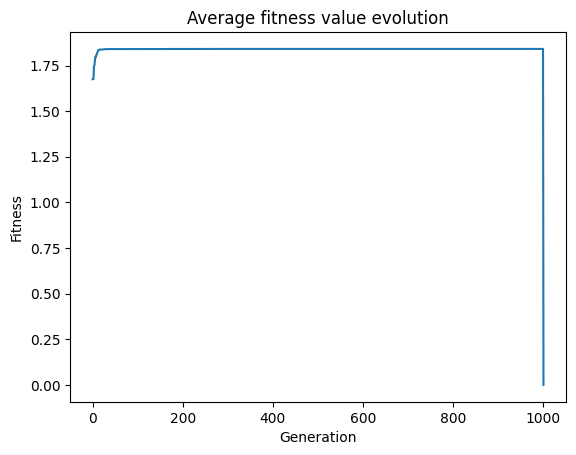

In [148]:
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

# Plot the average fitness value evolution
plt.plot(evolution_curve)
plt.title("Average fitness value evolution")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.show()


In [149]:
print(evolution_curve)

[1.675079687979252, 1.675079687979252, 1.675079687979252, 1.7448550905066413, 1.7492513996630636, 1.7754196928311416, 1.7957949491798, 1.7957949491798, 1.8070845595730334, 1.8080219353604572, 1.816482741965645, 1.8241058796207454, 1.8294987361752422, 1.8354155950901407, 1.8354155950901407, 1.8371232825901926, 1.8371232825901926, 1.8371232825901926, 1.8371232825901926, 1.8371232825901926, 1.8371232825901926, 1.837775795815627, 1.837792805584841, 1.837792805584841, 1.838155645512531, 1.8385881798525112, 1.839269005155316, 1.839616224746254, 1.839616224746254, 1.8397706513580099, 1.8398228349088424, 1.8398228349088424, 1.8398228349088424, 1.8398229558824397, 1.8398229558824397, 1.8398229558824397, 1.8398308174113969, 1.8399833144967837, 1.8399833144967837, 1.8399833144967837, 1.8399833144967837, 1.8399833144967837, 1.8399833144967837, 1.8399833144967837, 1.8399833144967837, 1.8399890609979925, 1.840022170093238, 1.840022170093238, 1.840022170093238, 1.8400316324706987, 1.8400518792175196,